In [1]:
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Use runtime, if you use ibm cloud quantum computer
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# from qiskit_ibm_runtime import EstimatorV2 as Estimator
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# Use aer, if you simulate quantum computer locally
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler


from scipy.optimize import minimize

import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [2]:
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

backend = AerSimulator(method="statevector")
backend.name

'aer_simulator'

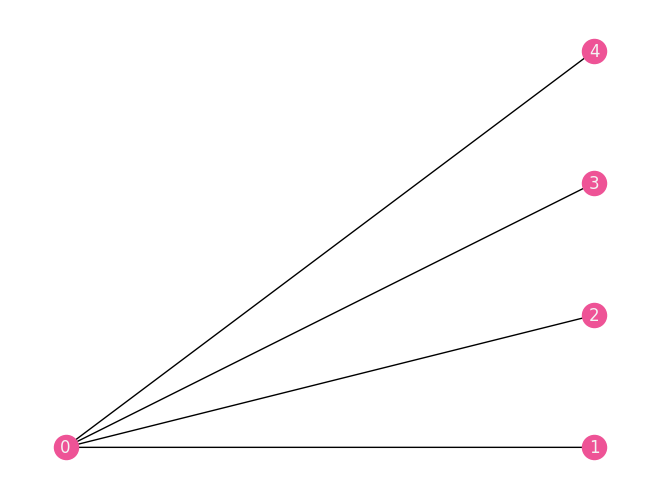

In [3]:
num_nodes = 5

# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]


G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

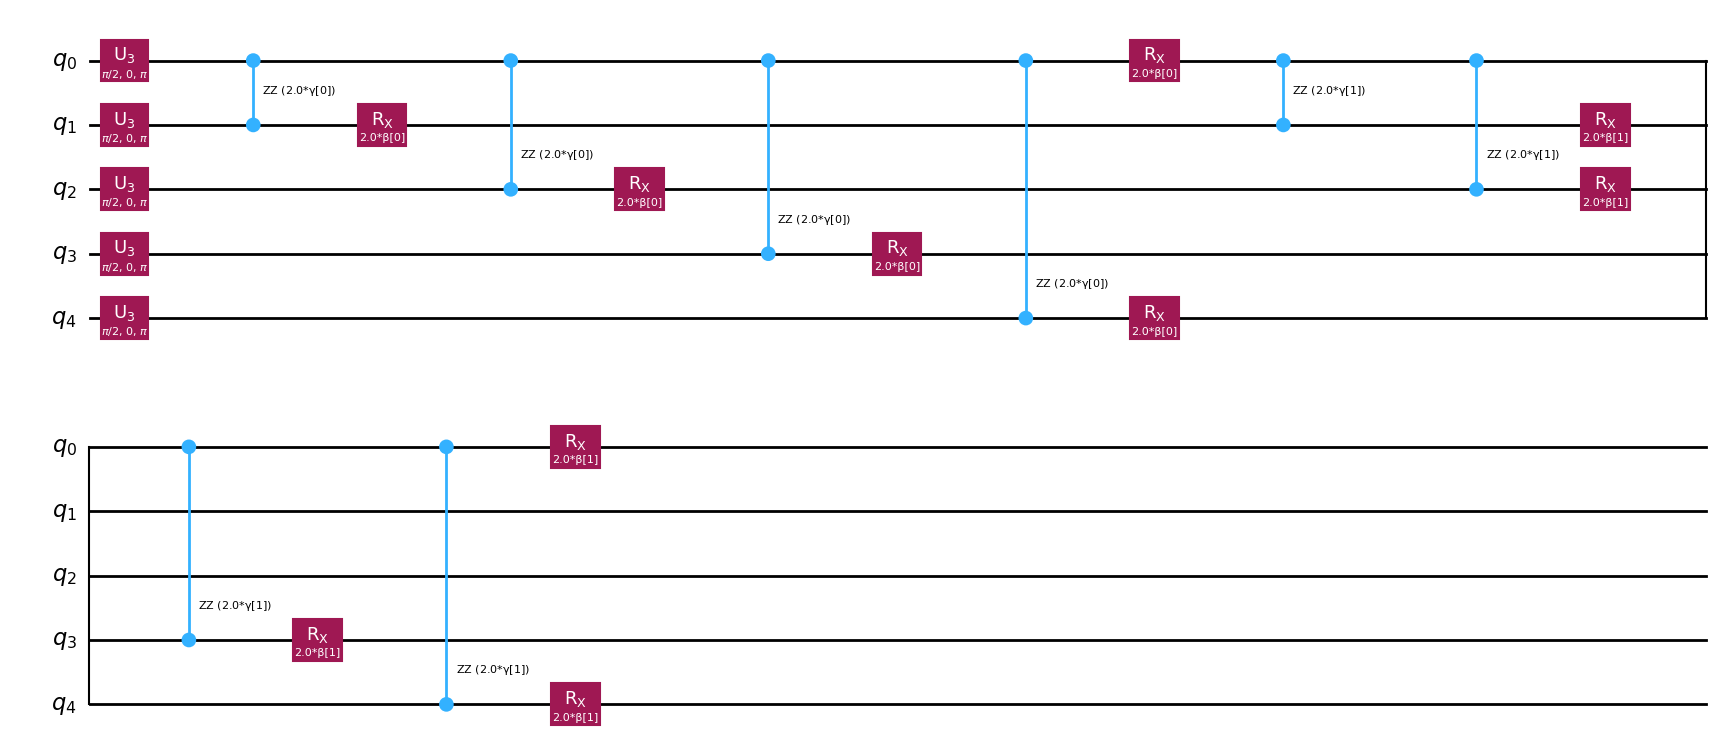

In [4]:
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])

ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

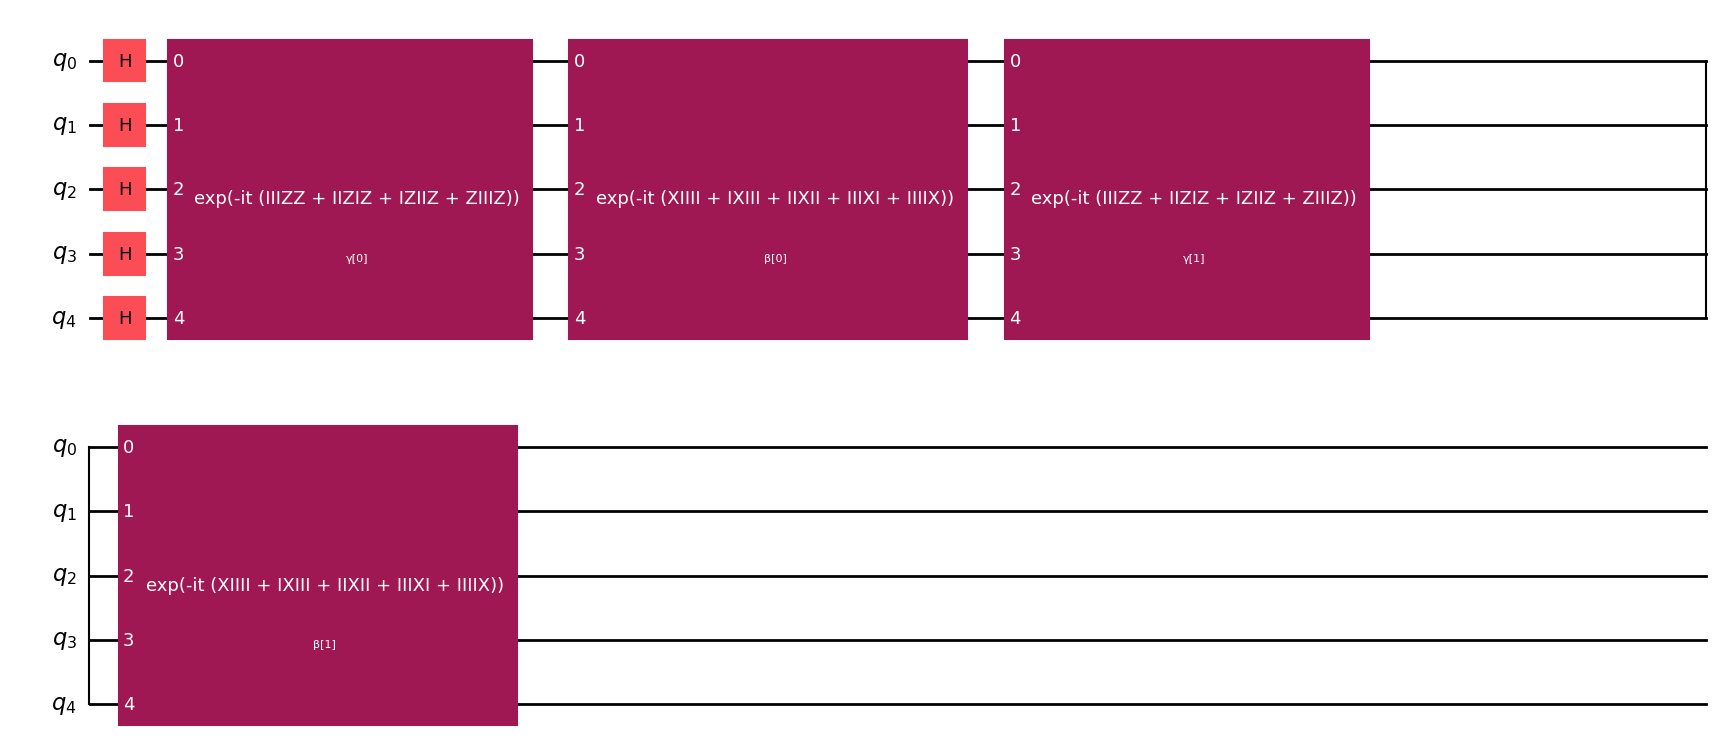

In [5]:
ansatz.decompose().draw(output="mpl", style="iqp")

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)

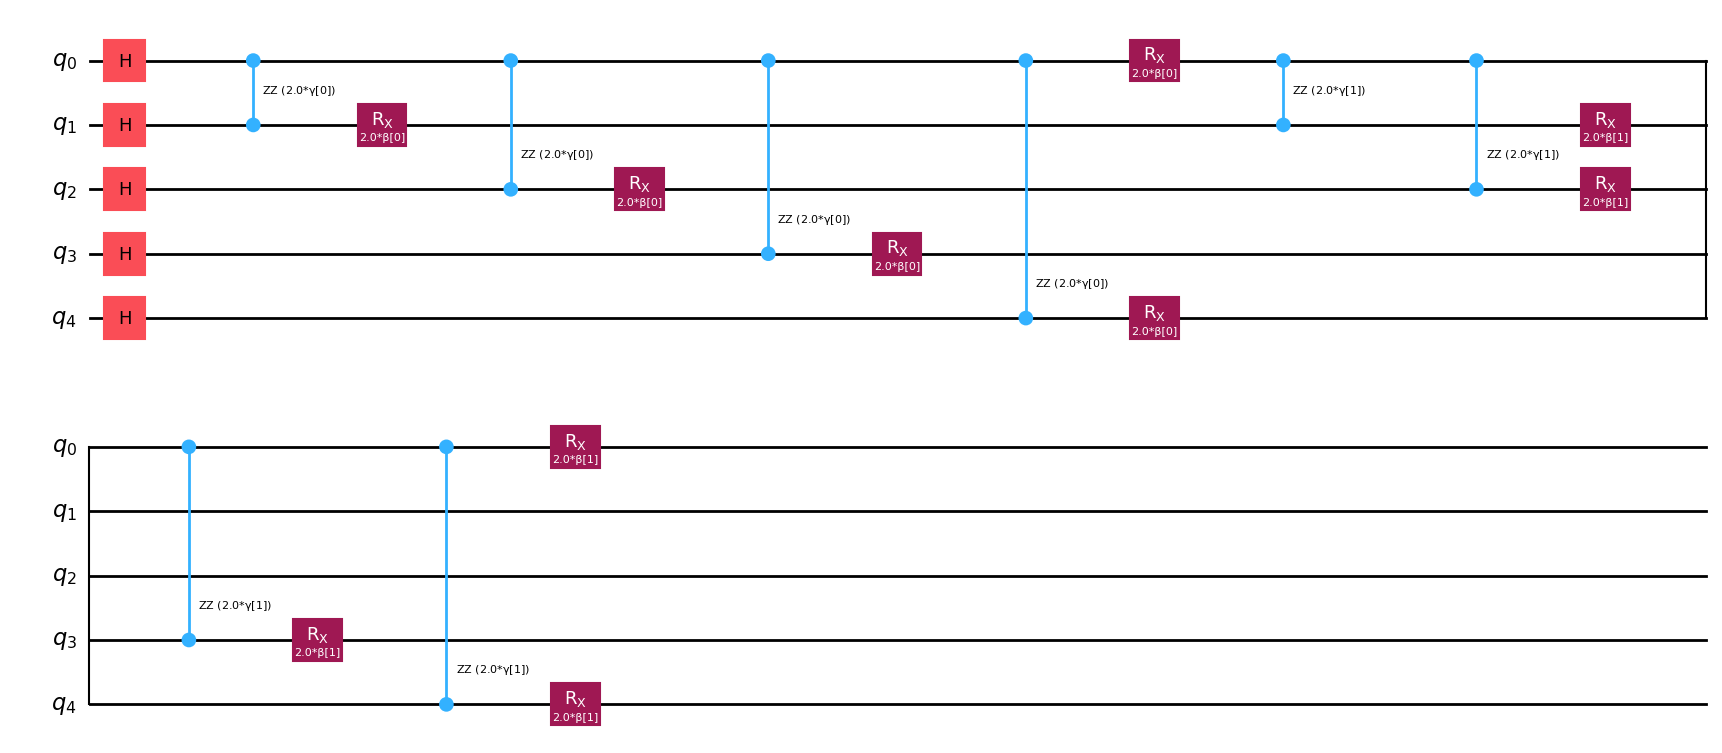

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [10]:
# session = Session(backend=backend)

# estimator = Estimator(session=session)
# estimator.options.default_shots = 10_000
# estimator.options.dynamical_decoupling.enable = True

# sampler = Sampler(session=session)
# sampler.options.default_shots = 10_000
# sampler.options.dynamical_decoupling.enable = True

from qiskit.primitives import StatevectorEstimator, StatevectorSampler

estimator = StatevectorEstimator()

sampler = StatevectorSampler(default_shots=10_000)

In [11]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [12]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [13]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.293925361555134
       x: [ 2.649e+00  5.949e+00  3.732e+00  6.724e+00]
    nfev: 92
   maxcv: 0.0

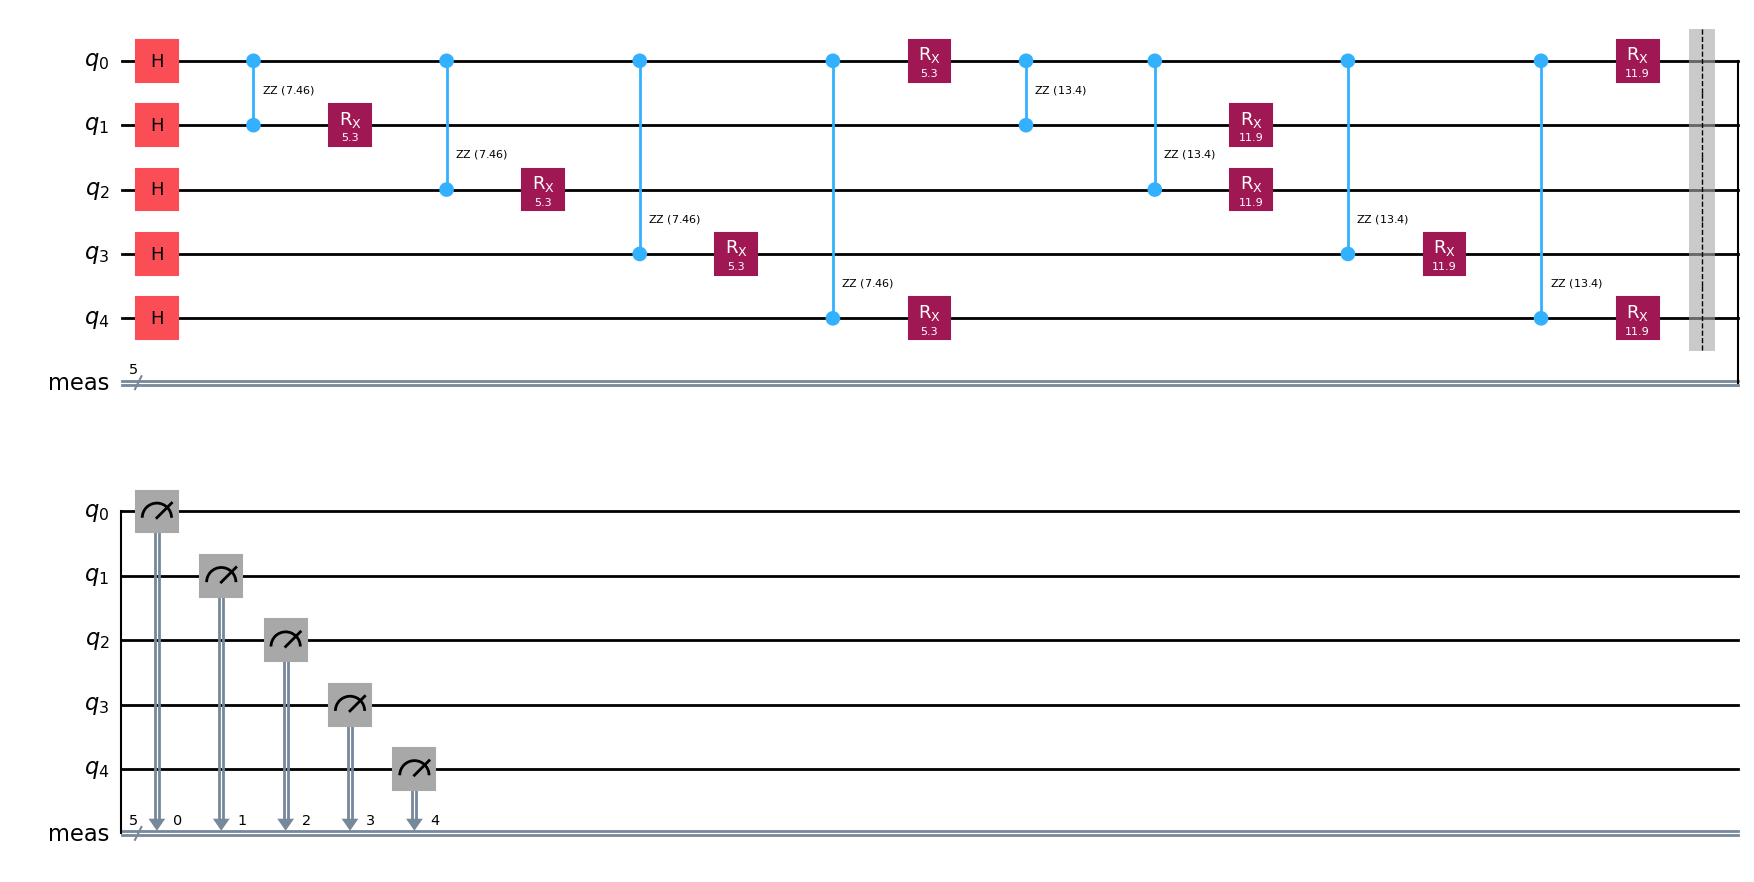

In [14]:
qc = ansatz.assign_parameters(res.x)

qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="idp")

In [15]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()

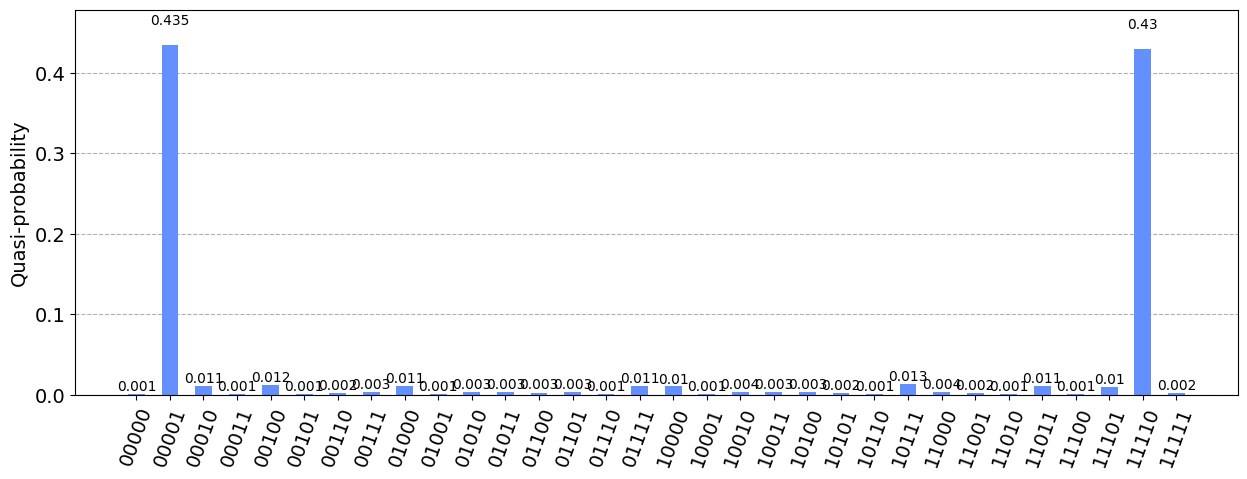

In [16]:
plot_distribution(samp_dist, figsize=(15, 5))

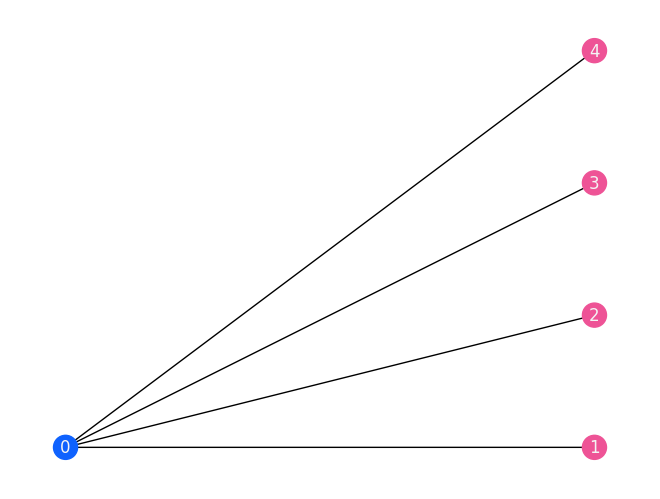

In [17]:
solution = [0, 1, 1, 1, 1]

mpl_draw(
    G,
    pos=rx.bipartite_layout(G, {0}),
    with_labels=True,
    node_color=["#EE5396" if kk else "#0f62FE" for kk in solution],
    font_color="#F4F4F4",
)

In [18]:
import qiskit
qiskit.version.get_version_info()

'1.0.2'